<a href="https://colab.research.google.com/github/StatsAI/streamlit_image_search/blob/main/E_commerce_reverse_image_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ecommerce: reverse image search

All e-commerce platforms need a search mechanism. The built-in methods usually rely on some variation of full-text search which finds the relevant documents based on the presence of the words used in a query. In some cases, it might be enough, but there are ways to improve that mechanism and increase sales. If your customer can easily find a product they need, they are more likely to buy it.

Semantic search is one of the possibilities. It relies not only on keywords but considers the meaning and intention of the query. However, reverse image search might be a way to go if you want to enable non-textual search capabilities. Your customers may struggle to express themselves, so why don't you ease that and start accepting images as your search queries?

# Amazon product dataset 2020

We will use the [Amazon product dataset 2020](https://www.kaggle.com/datasets/promptcloud/amazon-product-dataset-2020/) and see how to enable visual queries for it. The following lines will download it from the cloud and create a directory structure so you can reproduce the results independently.

In [1]:
!mkdir data
!mkdir data/images
!mkdir queries
!wget -nc --directory-prefix=data/ "https://storage.googleapis.com/qdrant-examples/amazon-product-dataset-2020.zip"
!wget -nc --directory-prefix=queries/ "https://storage.googleapis.com/qdrant-examples/ecommerce-reverse-image-search-queries.zip"
!unzip -u -d queries queries/ecommerce-reverse-image-search-queries.zip

--2023-07-20 17:15:20--  https://storage.googleapis.com/qdrant-examples/amazon-product-dataset-2020.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 142.250.107.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5627576 (5.4M) [application/zip]
Saving to: ‘data/amazon-product-dataset-2020.zip’

amazon-product-data 100%[===================>]   5.37M  4.85MB/s    in 1.1s    

2023-07-20 17:15:21 (4.85 MB/s) - ‘data/amazon-product-dataset-2020.zip’ saved [5627576/5627576]

--2023-07-20 17:15:21--  https://storage.googleapis.com/qdrant-examples/ecommerce-reverse-image-search-queries.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 142.250.107.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:443... connected.
HTTP request sent, awaiting response... 200 O

In [2]:
!pip install jupyter pandas sentence_transformers "qdrant_client~=1.3.0" pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.9 MB/s eta 0:00:00


The dataset is provided as a CSV file and contains multiple attributes of the products, including URLs of the product images. That gives us a real case to work on. Let's check the dataset structure and prepare it for further processing.

**For the testing purposes, we can use only a small subset of the dataset. It's enough to show the concept, but you can easily scale it to the whole dataset. The variable below is a fraction of the dataset that will be used for the rest of the notebook. Feel free to change it to `1.0` if you want to use the whole dataset.**

In [3]:
DATASET_FRACTION = 0.1

Now, we can load the dataset and see what it contains.

In [4]:
import pandas as pd
import zipfile

with zipfile.ZipFile("./data/amazon-product-dataset-2020.zip", "r") as z:
    with z.open("home/sdf/marketing_sample_for_amazon_com-ecommerce__20200101_20200131__10k_data.csv") as f:
        dataset_df = pd.read_csv(f).sample(frac=DATASET_FRACTION)

dataset_df.sample(n=5).T

,8663,7885,4712,1809,3603
Uniq Id,d3c1fbb870b9bb5954b408e01f63d737,5bfa18c6357db5622f98ca001c11abc0,b291113e627b36c8a93e07e46f336c69,218de61f0e0a3e6d044ac1c9f4124615,d688c4d30f7f543278453d950b65c67a
Product Name,Crocodile Creek 4130-1 Two-Sided Monkey Jungle...,Great Eastern Entertainment Moon Phase Kitty M...,Toomies Push & Go Plane,"PlaidHat pH1708 Crystal Clans: Gem Clan, Various",titan Flower Princess Multi-Sport Protective P...
Brand Name,NaN,NaN,NaN,NaN,NaN
Asin,NaN,NaN,NaN,NaN,NaN
Category,Toys & Games | Puzzles | Floor Puzzles,NaN,Toys & Games | Learning & Education,Toys & Games | Games & Accessories | Board Games,Sports & Outdoors | Outdoor Recreation | Cycli...
Upc Ean Code,NaN,NaN,NaN,NaN,NaN
List Price,NaN,NaN,NaN,NaN,NaN
Selling Price,$14.99,$4.18,$5.99,$9.95,$18.92
Quantity,NaN,NaN,NaN,NaN,NaN
Model Number,4130-1,3905,E72241,PH1708,9271


In [5]:
dataset_df.shape

(1000, 28)

In [6]:
dataset_df.iloc[0]["Image"]

'https://images-na.ssl-images-amazon.com/images/I/41yDi0qWTRL.jpg|https://images-na.ssl-images-amazon.com/images/G/01/x-locale/common/transparent-pixel.jpg'

It turns out a single product may have several images. They are stored in a pipe-separated string.

In [7]:
dataset_df.iloc[0]["Image"].split("|")

['https://images-na.ssl-images-amazon.com/images/I/41yDi0qWTRL.jpg',
 'https://images-na.ssl-images-amazon.com/images/G/01/x-locale/common/transparent-pixel.jpg']

The last entry is common for multiple products, so we can simply remove it.

In [8]:
dataset_df["Image"] = dataset_df["Image"].map(lambda x: x.split("|")[:-1])

In [9]:
dataset_df.iloc[0]["Image"]

['https://images-na.ssl-images-amazon.com/images/I/41yDi0qWTRL.jpg']

In [10]:
dataset_df = dataset_df.explode("Image").dropna(subset=["Image"])
dataset_df.sample(n=5).T

,4743,9809,1739,119,2490
Uniq Id,c70ff96dfda28e1f39ab96ecd849ed5c,ef62d21e9c5bc96fb19ac060679c3bc9,10e471ca0d7e9809ed9b1414370b6988,c0fd11e864d351e88e9df728bbaa486d,391201805b59ce86ba6dd9994dbbb413
Product Name,Optimus Prime Truck with Robot on Chassis from...,"Aurora 16"" Frog-Lette Fuffle",DC Comics: Batman (with Bonus Part) Ikemen Statue,Nations The Dice Game Unrest Expansion,Disney 2-in-1 Battery-Powered Frozen Train wit...
Brand Name,NaN,NaN,NaN,NaN,NaN
Asin,NaN,NaN,NaN,NaN,NaN
Category,Toys & Games | Play Vehicles | Die-Cast Vehicles,Toys & Games | Stuffed Animals & Plush Toys | ...,"Toys & Games | Collectible Toys | Statues, Bob...",Toys & Games | Games & Accessories,Toys & Games | Toy Figures & Playsets | Playse...
Upc Ean Code,NaN,NaN,NaN,NaN,NaN
List Price,NaN,NaN,NaN,NaN,NaN
Selling Price,$24.99,$17.89,$79.97,$36.91,$99.99
Quantity,NaN,NaN,NaN,NaN,NaN
Model Number,30446,16910,DC035,7070SG,060376


## Downloading the images

We want to create the embeddings out of the images, but we need to have them downloaded in the first place.

In [11]:
dataset_df = dataset_df.sample(frac = 0.05)
dataset_df.shape

(169, 28)

In [12]:
from typing import Optional

import urllib
import os

def download_file(url: str) -> Optional[str]:
    basename = os.path.basename(url)
    target_path = f"./data/images/{basename}"
    if not os.path.exists(target_path):
        try:
            urllib.request.urlretrieve(url, target_path)
        except urllib.error.HTTPError:
            return None
    return target_path

In [13]:
import numpy as np

# Our download_file function returns None in case of any HTTP issues.
# We can use that property to filter out the problematic images.
dataset_df["LocalImage"] = dataset_df["Image"].map(download_file).replace({None: np.nan})
dataset_df = dataset_df.dropna(subset=["LocalImage"])
dataset_df.sample(n=5).T

,6148,1274,2069,6491,9842
Uniq Id,b691ff9af9c48c4d3890cda193caaebc,ff2d9b91f16ccd82704617dd4b833eba,95869e007e113c281b757ef88808ffe8,0d45672b2e485502aef4b2908473f23b,71c48d179f670967e121ca4096b189a2
Product Name,Barbie BMR1959 Fully Poseable Fashion Doll wit...,LeapFrog Number Lovin' Oven (Frustration Free ...,T.O.T.S. Nursery Stroller Packaging,Craft-tastic Needle Felt Pillow Kit,MightySkins Skin Compatible With DJI Spark Dro...
Brand Name,NaN,NaN,NaN,NaN,NaN
Asin,NaN,NaN,NaN,NaN,NaN
Category,Toys & Games | Dolls & Accessories | Dolls,Toys & Games | Kids' Electronics | Electronic ...,Toys & Games | Dress Up & Pretend Play | Prete...,Toys & Games | Arts & Crafts | Craft Kits | Fe...,Toys & Games | Hobbies | Remote & App Controll...
Upc Ean Code,NaN,NaN,NaN,NaN,NaN
List Price,NaN,NaN,NaN,NaN,NaN
Selling Price,$19.99,$19.29,$39.97,$4.39,$49.97
Quantity,NaN,NaN,NaN,NaN,NaN
Model Number,GHT91,80-19347E,49161,CT1522,DJSPCMB-Cherry Grain


## Creating the embeddings

There are various options for creating the embeddings out of our images. But do not even think about training your neural encoder from scratch! Plenty of pre-trained models are available, and some may already give you some decent results in your domain. And if not, you can use them as a base for the fine-tuning that might be done way faster than the full training.

### Available options

Using the pretrained models is easy if you choose a library that exposes them with a convenient interface. Some of the possibilities are:

- [torchvision](https://pytorch.org/vision/stable/index.html) - part of PyTorch
- [embetter](https://koaning.github.io/embetter/) - if you prefer using pandas-like API, that's a great choice
- [Sentence-Transformers](https://www.sbert.net/examples/applications/image-search/README.html) - one of the standard libraries for NLP exposes OpenAI CLIP model as well

### Choosing the right model

If you run an e-commerce business, you probably already have a standard full-text search mechanism. Reverse image search is one option to enrich the user experience, but if you also want to experiment with [hybrid search](https://qdrant.tech/articles/hybrid-search/), you should keep that in mind from the beginning. If that's your scenario, it's better to consider multimodality from day one. Such a model can encode texts and images in the same vector space.

For that reason, we are going to use the OpenAI CLIP model, so in the future, we can extend our search mechanism with a semantic search using the same component.

In [14]:
from sentence_transformers import SentenceTransformer
from PIL import Image

model = SentenceTransformer("clip-ViT-B-32")

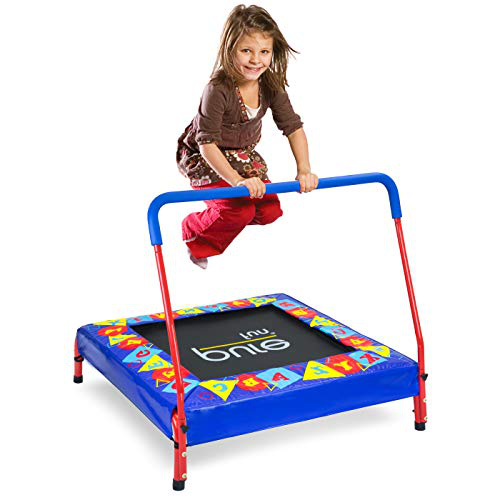

In [15]:
image = Image.open(dataset_df.iloc[0]["LocalImage"])
image

In [16]:
image_embedding = model.encode(image)
image_embedding.shape

(512,)

In [17]:
image_embedding

array([-1.03252470e-01,  1.93549991e-01,  1.62947506e-01,  2.95131356e-01,
        8.79333466e-02, -1.20649330e-01,  1.25370383e-01,  1.22517541e-01,
        1.56298041e-01, -7.20038712e-02,  9.04408172e-02, -5.15238702e-01,
        3.22012484e-01, -3.93121541e-01,  1.92495808e-01, -3.62876728e-02,
        5.90539053e-02,  1.82585090e-01,  1.40300423e-01, -7.17197835e-01,
       -7.14771032e-01,  2.37939909e-01,  1.78817272e-01, -5.72317183e-01,
       -3.95892560e-01,  2.08595008e-01, -9.95989144e-02, -2.36101210e-01,
       -3.35429668e-01, -4.47220653e-01,  2.36737370e-01,  3.86414498e-01,
       -1.60730541e-01,  9.75957513e-02, -9.60823894e-02, -4.54149425e-01,
       -2.72599459e-01,  1.54291838e-02, -6.67962730e-02,  1.02678567e-01,
       -5.62286526e-02, -2.94691831e-01, -2.18087852e-01, -2.50007838e-01,
        1.46388873e-01,  6.44075215e-01,  3.03046763e-01, -3.22150290e-01,
       -3.10641788e-02, -3.41717482e-01,  6.21164322e-01,  1.01148441e-01,
        1.84024394e-01,  

That's what a single embedding look like. But we need to calculate them for each image in our dataset.

In [18]:
from typing import List

def calculate_embedding(image_path: str) -> Optional[List[float]]:
    try:
        image = Image.open(image_path)
        return model.encode(image).tolist()
    except:
        return None

In [19]:
# Again, our helper function returns None in case of any error, such as
# unsupported image format. We need to remove those entries.
dataset_df["Embedding"] = dataset_df["LocalImage"].map(calculate_embedding)
dataset_df["Embedding"] = dataset_df["Embedding"].replace({None: np.nan})
dataset_df = dataset_df.dropna(subset=["Embedding"])
dataset_df.sample(n=5).T

,8546,9842,2932,5580,3470
Uniq Id,bbf8b118ebbb6bf0a625df28fd528b67,71c48d179f670967e121ca4096b189a2,4a96c75e3ad9e9413f2efe3de38148b4,086a1672f2cf1e7bac274fbec7be36e9,9057dab02cd2f53dfdfb54688237f663
Product Name,"SunWorks Construction Paper, White, 9"" x 12"", ...",MightySkins Skin Compatible With DJI Spark Dro...,Breyer 2050 Traditional English Riding Set - H...,Buffalo Games - Charles Wysocki - Proud Lil' A...,Plus-Plus BIG - Preschool Construction Buildin...
Brand Name,NaN,NaN,NaN,NaN,NaN
Asin,NaN,NaN,NaN,NaN,NaN
Category,"Arts, Crafts & Sewing | Crafting | Paper & Pap...",Toys & Games | Hobbies | Remote & App Controll...,NaN,Toys & Games | Puzzles | Jigsaw Puzzles,Toys & Games | Building Toys | Building Sets
Upc Ean Code,NaN,NaN,NaN,NaN,NaN
List Price,NaN,NaN,NaN,NaN,NaN
Selling Price,$2.09,$49.97,$27.49,$12.99,$29.99
Quantity,NaN,NaN,NaN,NaN,NaN
Model Number,9203,DJSPCMB-Cherry Grain,B00HV97QOQ,11470,03230


In [20]:
dataset_df.to_parquet("./data/amazon-with-embeddings.parquet")

## Indexing embeddings in Qdrant

Reverse image search compares the embeddings of the image used as a query and the embeddings of the indexed pictures. That can be theoretically done in a naive way by comparing the query to every single item from our store, but that won't scale if we even go beyond a few hundred. That's what the vector search engines are designed for. Qdrant acts as a fast retrieval layer that performs an efficient search for the closest vectors in the space.

There are various ways to start using Qdrant, and even though the local mode in Python SDK is possible, it should be running as a service in production. The easiest way is to use a Docker container, which we'll do.

In [21]:
!docker run -d -p "6333:6333" -p "6334:6334" --name "reverse_image_search" qdrant/qdrant:v1.3.0

/bin/bash: line 1: docker: command not found


In [22]:
from qdrant_client import QdrantClient
from qdrant_client.http import models as rest

try:
    client = QdrantClient("localhost")
    collections = client.get_collections()
except Exception:
    # Docker is unavailable in Google Colab so we switch to local
    # mode available in Python SDK
    client = QdrantClient(":memory:")
    collections = client.get_collections()

collections

CollectionsResponse(collections=[])

In [23]:
client.recreate_collection(
    collection_name="amazon",
    vectors_config=rest.VectorParams(
        size=512,
        distance=rest.Distance.COSINE,
    )
)

True

It's a good practice to use batching while inserting the vectors into the collection. Python SDK has a utility method that performs it automatically. For the purposes of our demo, we're going to store vectors with the product id, name, and description as a payload.

In [24]:
payloads = dataset_df[["Uniq Id", "Product Name", "About Product", "Image", "LocalImage"]] \
    .fillna("Unknown") \
    .rename(columns={"Uniq Id": "ID",
                     "Product Name": "Name",
                     "About Product": "Description",
                     "LocalImage": "Path"}) \
    .to_dict("records")
payloads[0]

{'ID': '196f4917315159c6e17fd014ac296d03',
 'Name': 'Pure Fun 36-inch Preschool Jumper Kids Trampoline with Handrail, Ages 3 to 7',
 'Description': 'Make sure this fits by entering your model number. | Spring system is covered with mesh and cushioning to create a safe, worry-free bouncing environment for your children to play and develop their coordination, balance, leg muscles, and stamina | Ergonomic inclined safety bar for increased security and stability; Soft, cushioned handle for firmer, more comfortable gripping | Bouncing system is ASTM, TUV/GS and CE certified for safety; Easy and quick assembly, no additional tools necessary for assembly | Bright, attractive pattern encourages shape, color and ABC recognition; Trampoline dimensions are 36 L x 36 W x 35 H inches including handrail | Frame is sturdy and durable and is capable of sustaining bouncing up to a weight capacity of 75 lbs.; Recommended for ages 3 to 7',
 'Image': 'https://images-na.ssl-images-amazon.com/images/I/41n0j

In [25]:
import uuid

client.upload_collection(
    collection_name="amazon",
    vectors=list(map(list, dataset_df["Embedding"].tolist())),
    payload=payloads,
    ids=[uuid.uuid4().hex for _ in payloads],
)

In [26]:
client.count("amazon")

CountResult(count=168)

## Running the reverse image search

As soon as we have the data indexed in Qdrant, it may already start acting as our reverse image search mechanism. Our queries no longer can be just textual, but we can freely use images to find similar items. For that, we surely need a query, and that will rarely be an image from the dataset. Let's find some different examples - for example from [Unsplash](https://unsplash.com), which is a source of freely usable images.

In [27]:
from io import BytesIO

import base64

def pillow_image_to_base64(image: Image) -> str:
    """
    Convert a Pillow image to a base64 encoded string that can be used as an image
    source in HTML.
    :param image:
    :return:
    """
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return f"data:image/jpeg;base64,{img_str}"

,,,

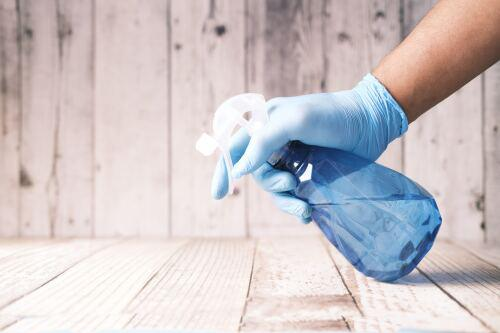
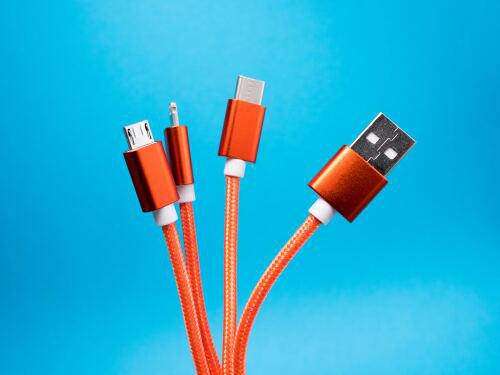
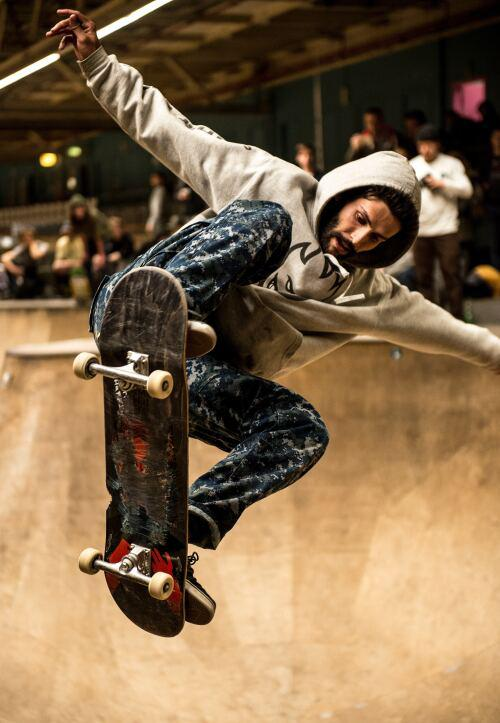
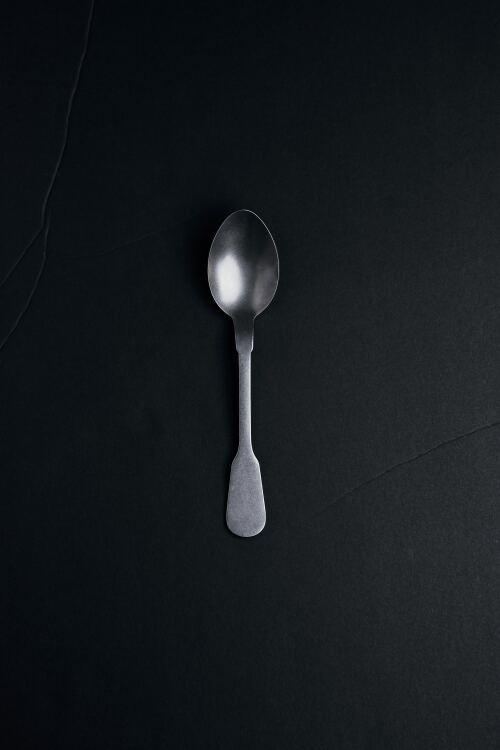

In [28]:
from IPython.display import display, HTML

import glob

query_image_paths = list(glob.glob("./queries/*.jpg"))
images_html = "".join(
    f"<td><img src='{pillow_image_to_base64(Image.open(path))}' width=150></td>"
    for path in query_image_paths
)
display(HTML(f"<table><tr>{images_html}</tr></table>"))

,,,,,

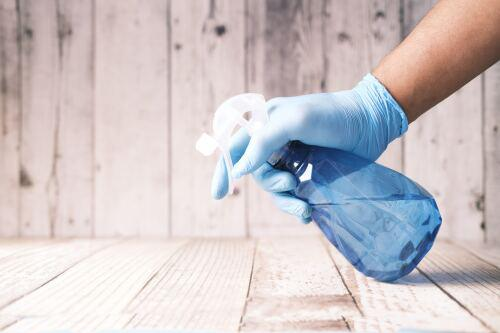

,,,,,

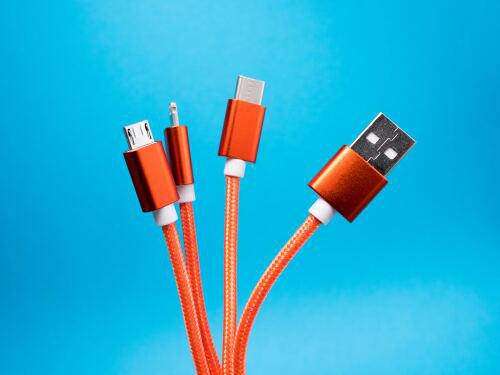

,,,,,

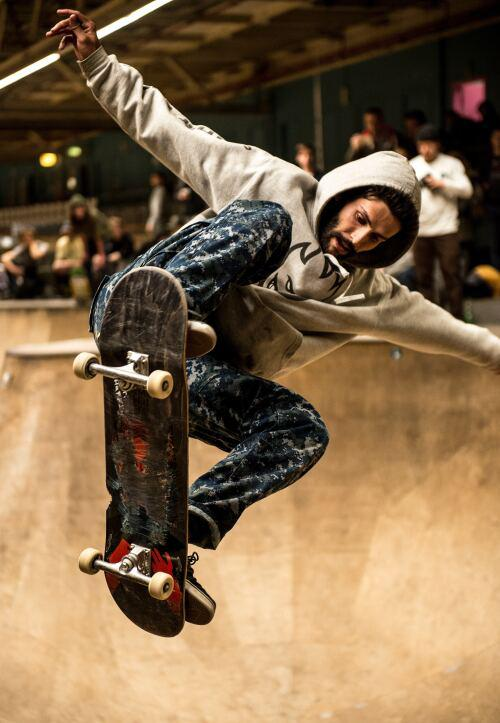

,,,,,

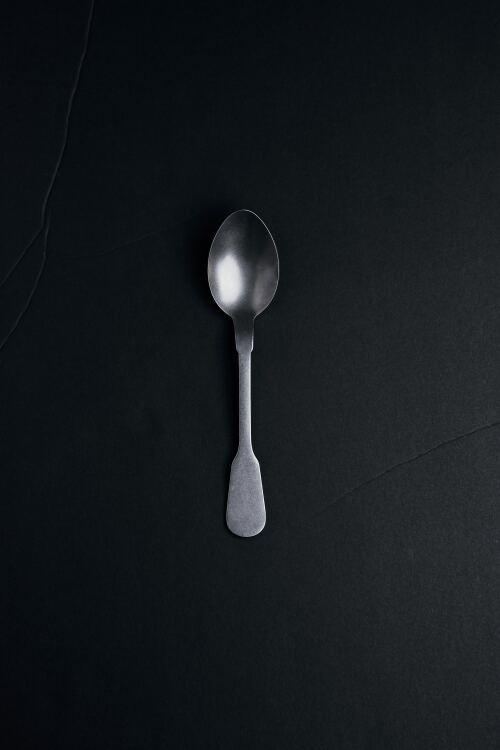

In [29]:
for query_image_path in query_image_paths:
    query_image = Image.open(query_image_path)
    query_embedding = model.encode(query_image)

    results = client.search(
        collection_name="amazon",
        query_vector=query_embedding,
        with_payload=True,
        limit=5,
    )

    output_images = [
        pillow_image_to_base64(Image.open(query_image_path)),
    ]
    for result in results:
        output_images.append(result.payload["Image"])

    images_html = "".join(
        f"<td><img src='{path}' width=150></td>"
        for path in output_images
    )
    display(HTML(f"<table><tr>{images_html}</tr></table>"))

We've implemented a reverse image search mechanism for e-commerce within a single notebook. We can kill the running Docker container for now, so nothing is left dangling in our environment.

In [30]:
!docker kill reverse_image_search
!docker rm reverse_image_search

/bin/bash: line 1: docker: command not found
/bin/bash: line 1: docker: command not found


## Futher steps

The notebook shows the general pipeline of encoding the inventory and using Qdrant to perform the reverse image search. There are, however, some challenges you may encounter while trying to implement it in the real world:

1. Pretrained models are great to start with but may struggle for some specific kinds of inventory if not trained on similar examples. You can always fine-tune them with small amounts of data to avoid a full training cycle.
2. Models should not be hosted within Jupyter notebooks, but there are some ways to serve them efficiently. We're going to describe the possibilities in a separate tutorial.
3. If you don't want to worry about maintaining another system in your stack, please consider using [Qdrant Cloud](https://cloud.qdrant.io/), our managed solution. Our tier is free forever and available to everyone - no credit card is required.